In [1]:
# Standart modules
import pandas as pd
import numpy as np

# Modules for graphics
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
sns.set_theme(style="ticks")

# Modules for typization
from typing import Union, List, Tuple, TypeVar
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')
PandasSeries = TypeVar('pandas.core.series.Series')

# Modules for statistics and models
from statsmodels.tsa.stattools import kpss, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.api import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV, SlidingWindowSplitter

from sklearn.metrics import mean_squared_error, mean_absolute_error

import arch
from arch import arch_model
from arch.__future__ import reindexing

# Operational modules
import warnings
import os
from tqdm.notebook import tqdm

# Module for getting data
import yfinance as yf




# Contents

**[Introduction](#Introduction)**

**[1. Analysing Data](#subparagraph1)**
   * [1.1. Getting S&P500 data from Yahoo!](#subsubparagraph1)
   * [1.2. Getting VIX data from Yahoo!](#subsubparagraph2) 
   * [1.3. Descriptive Statistics](#subsubparagraph3) 
   * [1.4. First and Second difference of data analysis](#subsubparagraph4) 
   * [1.5. Correlation Matrix](#subsubparagraph5) 
   * [1.6. Stationarity check (KPSS Test)](#subsubparagraph6)
   * [1.7 Granger Casuality Test](#subsubparagraph7)
   * [1.8. Final data](#data)



**[2. Using Models for Price Prediction](#subparagraph2)**
   * [2.1. ARIMA](#subsubparagraph9) 
   * [2.2. GARCH](#subsubparagraph10) 
   * [2.3. VAR](#subsubparagraph11) 


**[3. Strategies Realisation](#subparagraph3)**
   * [3.1 Simple Bollinger Bands](#subsubparagraph11)
   * [3.2 Bollinger Bands + VAR](#subsubparagraph12) 
   * [3.3 Bollinger Bands (2 SD GARCH Volatility) + VAR](#subsubparagraph14) 
   * [3.4 Bollinger Bands + 1 Min MACD](#subsubparagraph15) 
   * [3.5 Bollinger Bands + VAR + 1 Min MACD](#subsubparagraph16)
   * [3.6. Buy&Hold or Sell&Hold strategy](#subsubparagraph17)


## Introduction <a name="Introduction"></a>

In this work i will replicate of the article **"A Linear Process Approach to Short-term Trading Using the VIX Index as a Sentiment Indicator" by Yawo Mamoua Kobara, Cemre Pehlivanoglu, Okechukwu Joshua Okigbo**.

During my work i faced some diffuculties, so my work will have next differences in comparison to article:
> * **1.**   &nbsp; Dataset is taken from 2021-02-01 to 2023-01-01
> * **2.**  &nbsp;  Hourly dataset will be used (in the article it is 15-second dataset)

## 1. Analysing data <a name="subparagraph1"></a>

###### 1.1. Getting S&P500 data from Yahoo! <a name="subsubparagraph1"></a>

In [2]:
stock = yf.Ticker("^GSPC")
stock = stock.history(start="2021-02-01", end="2023-01-01", interval = "1h")
stock.rename(columns={"Open": "SPY Open", 
                      "High": "SPY High", 
                      "Low": "SPY Low",
                      "Close": "SPY Last",
                      "Volume": "SPY Vol"}, inplace = True)
stock.drop(['Dividends','Stock Splits'], axis = 1, inplace = True)

###### 1.2. Getting VIX data from Yahoo! <a name="subsubparagraph2"></a>

In [3]:
vix  = yf.Ticker("^VIX")
vix = vix.history(start="2021-02-01", end="2023-01-01", interval = "1h")
vix.rename(columns={  "Open": "VIX Open", 
                      "High": "VIX High", 
                      "Low": "VIX Low",
                      "Close": "VIX Last"}, inplace = True)
vix.drop(['Volume','Dividends','Volume','Stock Splits'], axis = 1, inplace = True)


###### Concatenating both time series

In [4]:
df = pd.concat([vix, stock], join='inner', axis = 1)

###### 1.3. Descriptive statistics  <a name="subsubparagraph3"></a>

In [5]:
np.round(df.describe(),2)

,VIX Open,VIX High,VIX Low,VIX Last,SPY Open,SPY High,SPY Low,SPY Last,SPY Vol
count,3382.00,3382.00,3382.00,3382.00,3382.00,3382.00,3382.00,3382.00,3.382000e+03
mean,22.66,23.02,22.32,22.63,4201.44,4211.02,4191.47,4201.47,2.167095e+08
std,4.98,5.12,4.86,4.98,297.45,296.06,298.69,297.39,1.131242e+08
min,14.54,14.62,14.47,14.55,3520.37,3550.97,3491.58,3530.91,0.000000e+00
25%,18.35,18.64,18.07,18.33,3939.52,3947.37,3929.29,3939.66,1.738116e+08
50%,21.99,22.30,21.66,21.90,4197.89,4204.05,4190.83,4197.45,2.231062e+08
75%,26.10,26.52,25.76,26.07,4443.23,4451.25,4436.36,4443.48,2.831806e+08
max,37.90,38.94,35.73,37.98,4813.25,4818.62,4804.51,4813.23,6.309550e+08


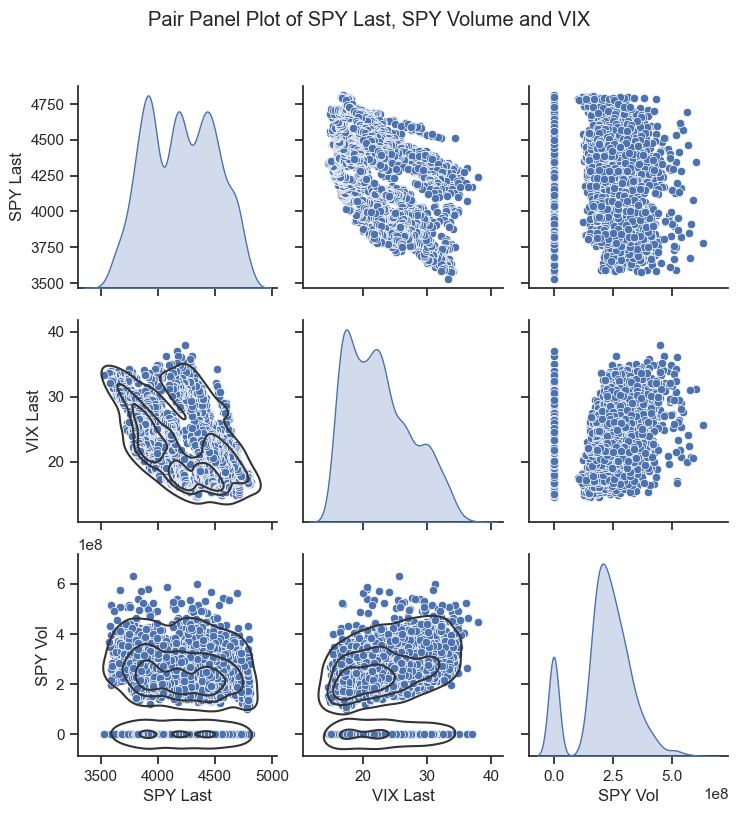

In [6]:
g = sns.pairplot(df[['SPY Last','VIX Last','SPY Vol']], diag_kind="kde")
g.fig.suptitle("Pair Panel Plot of SPY Last, SPY Volume and VIX", y=1.08)
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()


#### 1.4. First and Second difference of data analysis <a name="subsubparagraph4"></a>

In [7]:
def difference(dataset: PandasDataFrame, interval: int = 1 ) -> PandasSeries:
    
    'Function for finding first-dfference of given dataset'
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

#https://machinelearningmastery.com/difference-time-series-dataset-python/

In [8]:
#Calculating first difference of SNP and VIX
SPY_FD = difference(df['SPY Last']) 
VIX_FD = difference(df['VIX Last'])

In [9]:
#Calculating second difference of SNP and VIX
SPY_SD = difference(df['SPY Last'], interval = 2) 
VIX_SD = difference(df['VIX Last'], interval = 2)


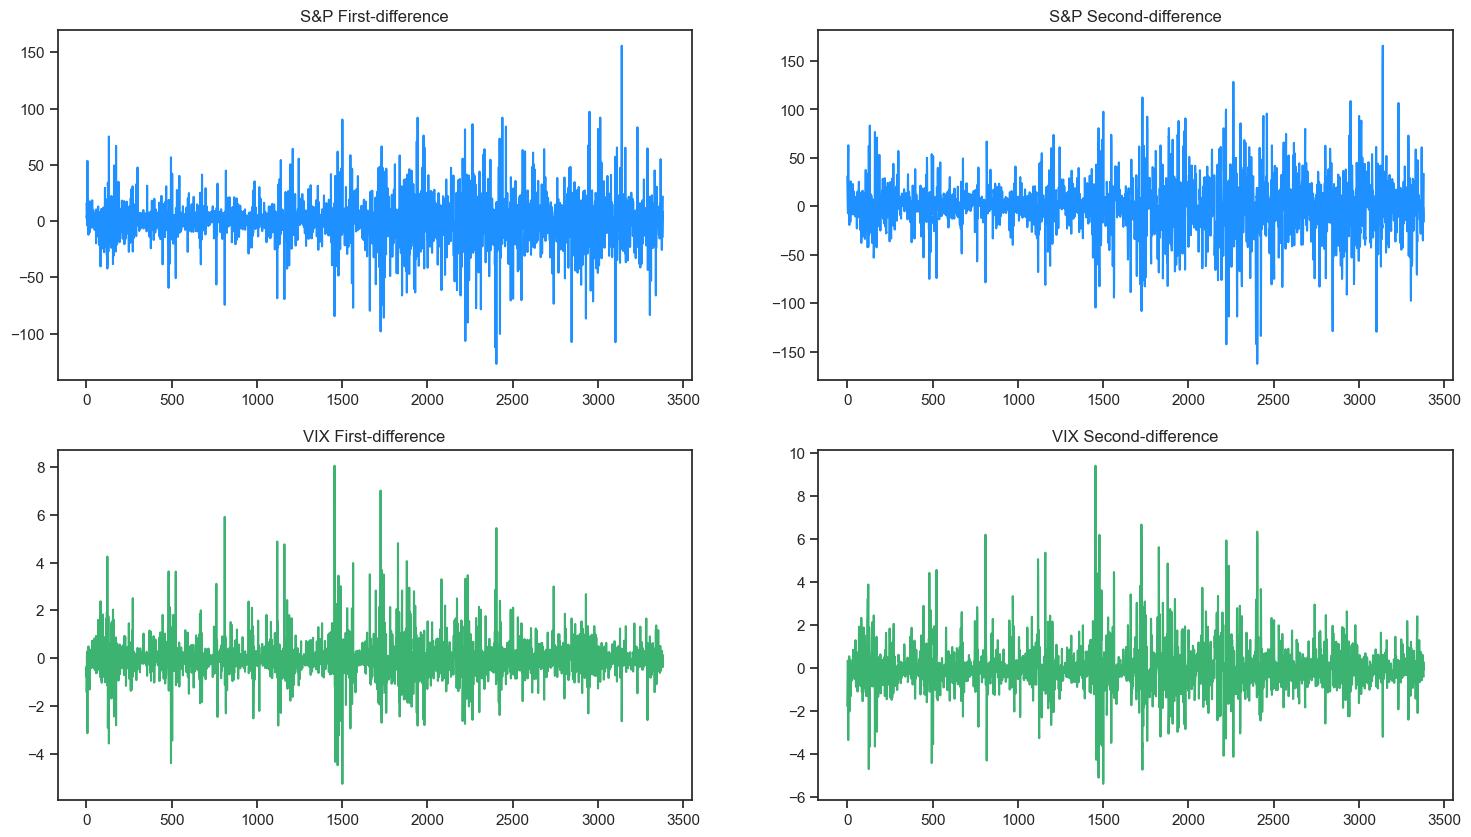

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0, 0].set_title('S&P First-difference')
sns.lineplot(ax=axes[0, 0], data = SPY_FD, color="dodgerblue")

axes[1, 0].set_title('VIX First-difference')
sns.lineplot(ax=axes[1, 0], data = VIX_FD, color="mediumseagreen")

axes[0, 1].set_title('S&P Second-difference')
sns.lineplot(ax=axes[0, 1], data = SPY_SD, color="dodgerblue")

axes[1, 1].set_title('VIX Second-difference')
sns.lineplot(ax=axes[1, 1], data = VIX_SD, color="mediumseagreen")

plt.show()


#### 1.5. Correlation Matrix <a name="subsubparagraph5"></a>

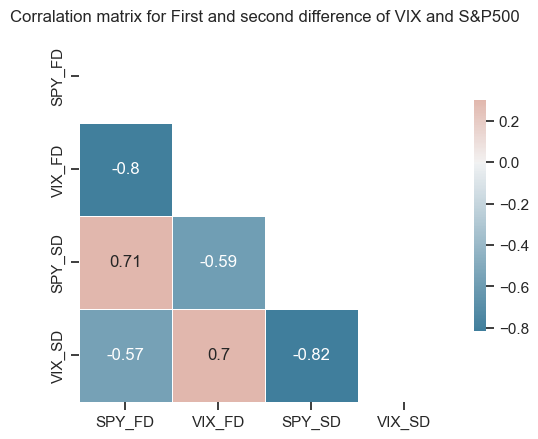

In [11]:
df_FD_SD = pd.DataFrame({'SPY_FD':SPY_FD, 'VIX_FD':VIX_FD, 'SPY_SD':SPY_SD, 'VIX_SD':VIX_SD})
corr = df_FD_SD.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_FD_SD.corr(), mask=mask,
            annot = True, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Corralation matrix for First and second difference of VIX and S&P500")
plt.show()


######  Conclusion: 

VIX and SPY data have strong correlation of first and second differenced data. So, we can suppose that there is some sort of connetction between VIX and SPY that can influence index.

#### 1.6. Stationarity check (KPSS Test) <a name="subsubparagraph6"></a>

KPSS test is used for testing stationarity of time series. 

> $H0:$  Time Series is stationary  $\\$ $H1:$ Time Series is NOT stationary


In [12]:
# https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
    #KPSS of SPY
    p_val_SPY_last = kpss(df['SPY Last'], regression='ct')[1]
    p_val_SPY_FD = kpss(SPY_FD, regression='ct')[1]
    p_val_SPY_SD = kpss(SPY_SD, regression='ct')[1]

    #KPSS of VIX
    p_val_VIX_last = kpss(df['VIX Last'], regression='ct')[1]
    p_val_VIX_FD = kpss(VIX_FD, regression='ct')[1]
    p_val_VIX_SD = kpss(VIX_SD, regression='ct')[1]

In [13]:
d = {'KPSS Test p-values': ['Level', 'First-differenced', 'Second-differenced'],
             'SPY Last': [p_val_SPY_last, p_val_SPY_FD, p_val_SPY_SD],
             'VIX Last': [p_val_VIX_last, p_val_VIX_FD, p_val_VIX_SD]}
pd.DataFrame(d)

,KPSS Test p-values,SPY Last,VIX Last
0,Level,0.01,0.01
1,First-differenced,0.10,0.10
2,Second-differenced,0.10,0.10


######  Conclusion: 

So, p-value of SPY Last and VIX Last is 0.1. It means there is no sufficient evidence to reject H0, meaning that stationarity of time series is not rejected. (Same result as in article)

#### 1.7. Granger Casuality Test <a name="subsubparagraph7"></a>

Granger Casuality test to determine if we can use one time series to predict another. 

> $H0:$  Time Series is useful for prediction of another  $\\$ $H1:$ Time Series is NOT useful for prediction of another

In that part will be test whether using VIX as time series useful for prediction S&P500 at different lags.

In [14]:
GC = grangercausalitytests(df[['SPY Last', 'VIX Last']], 6, verbose = False)
GC_FD = grangercausalitytests(df_FD_SD[['SPY_FD','VIX_FD']], 6, verbose = False)

GC_pvalue = []
GC_pvalue_FD = []
for i in range(1,7):
    GC_pvalue.append(GC[i][0]['ssr_ftest'][1])
    GC_pvalue_FD.append(GC_FD[i][0]['ssr_ftest'][1])
    
d = {'lag': ['1', '2', '3', '4', '5', '6'],
             'SPY raw data p-value': GC_pvalue,
             'SPY 1st difference p-value': GC_pvalue_FD}
np.round(pd.DataFrame(d).set_index('lag'),2)

,SPY raw data p-value,SPY 1st difference p-value
lag,,
1,0.71,0.05
2,0.16,0.04
3,0.09,0.06
4,0.13,0.01
5,0.03,0.03
6,0.04,0.01


######  Conclusion: 

So, first column (SPY raw data p-value) tells whether it will be useful to use VIX Last to predict SPY Last. For first lags there is no sufficient evidence to reject H0, that VIX Last will be useful. (For lags 1, 2, 4 H0 is not rejected).

Second columns tells whether it will be useful to use first difference VIX to predict first difference SPY. So, for any given lag there is enough evidence to rejected usefulness of first difference VIX atleast at 10% or lower level.

#### 1.8. Final Data  <a name="subsubparagraph8"></a>

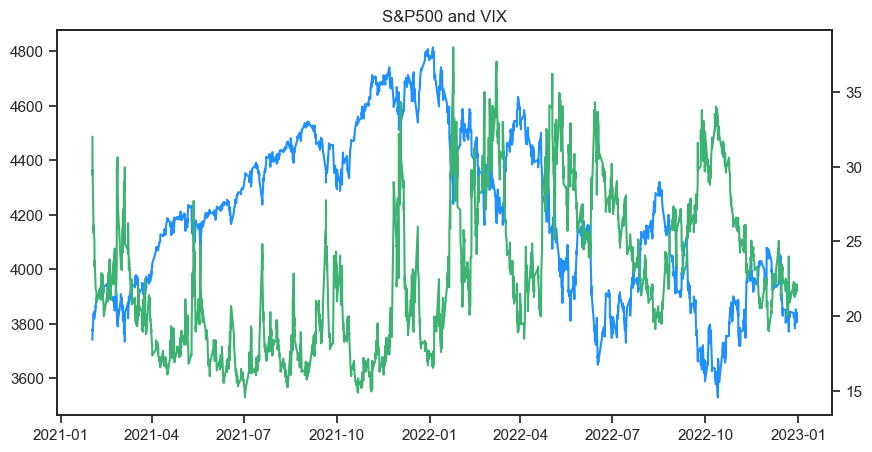

<Figure size 1800x1000 with 0 Axes>

In [15]:
fig,ax = plt.subplots(figsize=(10, 5))
plt.title("S&P500 and VIX")
ax.plot(df['SPY Last'],
        color="dodgerblue")

ax2=ax.twinx()
ax2.plot(df['VIX Last'],
        color="mediumseagreen")

figure(figsize=(18, 10))
plt.show()

In [16]:
df = df[['SPY Last','VIX Last']]
df = df.reset_index().drop('index', axis = 1)

train, validation = temporal_train_test_split(df, test_size = 0.4)

In [17]:
df.head(3)

,SPY Last,VIX Last
0,3741.469971,32.00
1,3757.189941,30.59
2,3772.459961,30.23


## 2. Using Models for Price Prediction <a name="subparagraph2"></a>

###  2.1.  Arima  <a name="subsubparagraph9"></a>

###### 2.1.1 without VIX

Finding optimal number of autoregressive terms (p), lagged forecast errors in the prediction equation (d), nonseasonal differences (q)

In [29]:
max_p = 5
max_q = 1
max_d = 2
orders = []

for p in range(max_p+1):
    for q in range(max_q+1):
        for d in range(max_d+1):
            orders.append((p, d, q))
            
# getting forecasting horizon        
fh = ForecastingHorizon(list(range(1, len(validation)+1)))

In [30]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

cv = SlidingWindowSplitter(fh=fh, window_length = 500, step_length = 100 )

gscv = ForecastingGridSearchCV(
    forecaster = ARIMA(),
    param_grid= {"order" : orders},
    cv=cv)
gscv.fit(np.array(train['SPY Last']))

pred = gscv.predict(fh)
variance = gscv.predict_interval(fh, coverage = 0.05)

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored whe

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Pred

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored whe

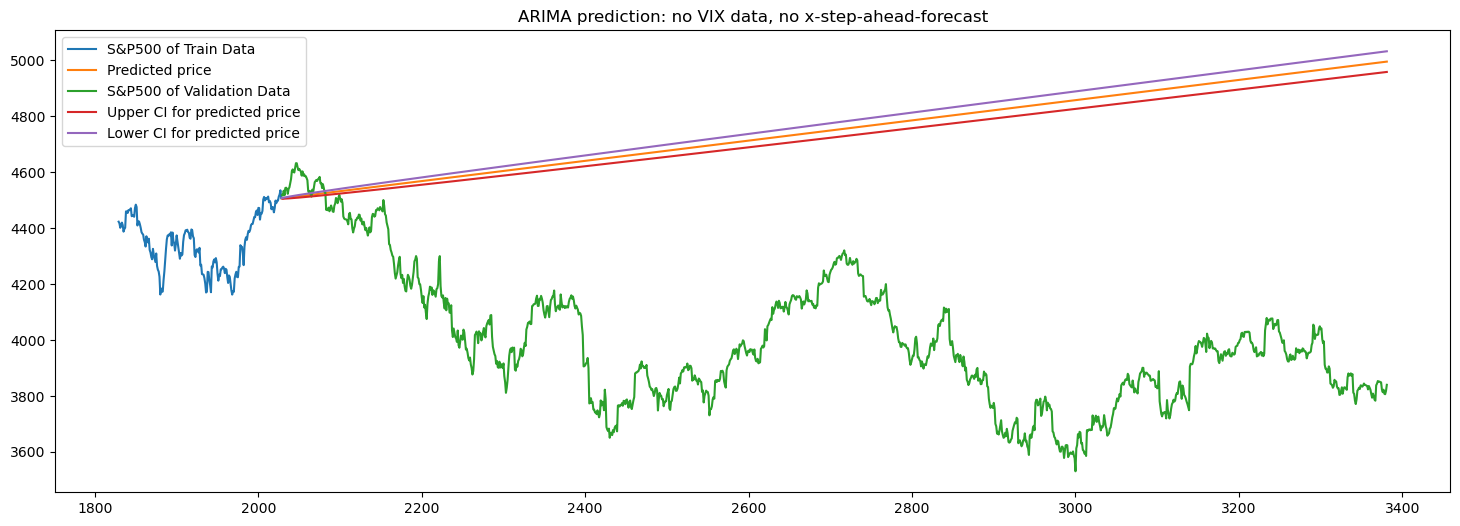

In [31]:
pred = gscv.best_forecaster_.predict(fh)


plt.figure(figsize=(18,6)) 
train['SPY Last'].tail(200).plot(label='S&P500 of Train Data')
pred.plot(label='Predicted price')
validation['SPY Last'].plot(label='S&P500 of Validation Data')
variance['Coverage'][0.05]['lower'].plot(label='Upper CI for predicted price')
variance['Coverage'][0.05]['upper'].plot(label='Lower CI for predicted price')
plt.title("ARIMA prediction: no VIX data, no x-step-ahead-forecast")
plt.legend()
plt.show()

In [32]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2029
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8449.582
Date:                Mon, 09 Jan 2023   AIC                          16909.164
Time:                        19:21:56   BIC                          16937.238
Sample:                             0   HQIC                         16919.465
                               - 2029                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3523      0.353      0.999      0.318      -0.339       1.044
ar.L1          0.0263      0.018      1.433      0.152      -0.010       0.062
ar.L2          0.0236      0.018      1.331      0.183      -0.011       0.058
ar.L3         -0.0246      0.020     -1.207      0.228      -0.064       0.015
sigma2       243.6178      3.643     66.875      0.000     236.478     250.758
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4088.97
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### x-step-forecasting for ARIMA on S&P500 without VIX information

In [36]:
def x_step_forecast(fh, x: int, window: int, forecaster, train, validation, endog, exog = None):  
    
    predictions = pd.Series(dtype = 'float64')
    variance = pd.Series(dtype = 'float64') # in progress
    
    for i in tqdm(range(0, len(fh), x)):
        
        window_to_update = pd.concat([train, validation])[len(train) - window + i : len(train) +  i]
        if exog == None:
            forecaster.update(window_to_update[endog])
            last_prediction = forecaster.predict(list(range(1, x+1)))
            last_variance = forecaster.predict_interval(list(range(1, x+1)), coverage = 0.05)

            
        else: 
            forecaster.update(window_to_update[endog], X = window_to_update[exog])
            if len(validation[exog].iloc[i:]) >= x:
                last_prediction = forecaster.predict(list(range(1, x+1)), X = validation[exog].iloc[i: x+i])
                
                last_variance = forecaster.predict_interval(list(range(1, x+1)), X = validation[exog].iloc[i: x+i], coverage = 0.05)

            else:
                leftovers = len(validation[exog].iloc[i:])
                last_prediction = forecaster.predict(list(range(1, leftovers+1)), X = validation[exog].iloc[i:])
                
                last_variance = forecaster.predict_interval(list(range(1, leftovers+1)), X = validation[exog].iloc[i: leftovers+i], coverage = 0.05)
        predictions = pd.concat([predictions, last_prediction])
        variance = pd.concat([variance, last_variance])
    return predictions, variance
    
def check_loss(validation, predictions):
    d = {'MSE': [np.round(mean_squared_error(validation['SPY Last'],predictions[0:len(validation)]),1)],
         'MAE': [np.round(mean_absolute_error(validation['SPY Last'],predictions[0:len(validation)]),1)],
         'RMSE': [np.round(mean_squared_error(validation['SPY Last'],predictions[0:len(validation)], squared=False),1)]}
    
    return pd.DataFrame(d)

  0%|          | 0/14 [00:00<?, ?it/s]

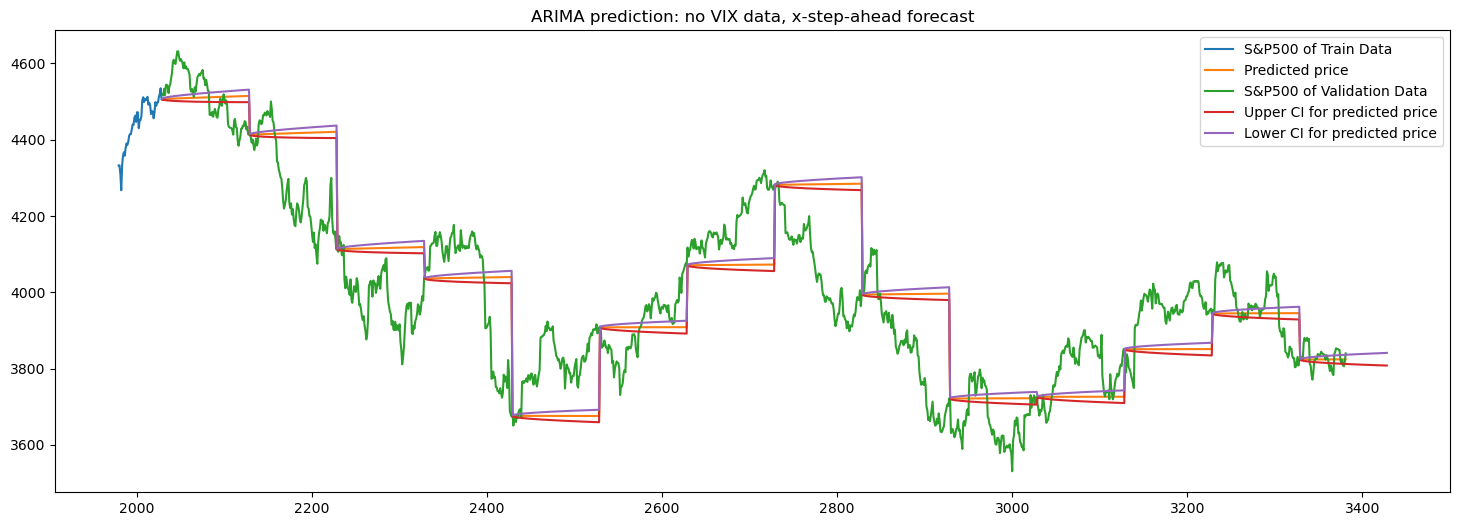

,MSE,MAE,RMSE
0,20149.3,113.3,141.9


In [37]:
fh = ForecastingHorizon(list(range(1, len(validation)+1)))
forecaster = gscv.best_forecaster_
predictions, variance = x_step_forecast(fh, 100, 500, forecaster, train, validation, 'SPY Last')

#plotting
plt.figure(figsize=(18,6)) 
train['SPY Last'].tail(50).plot(label='S&P500 of Train Data')
predictions[0:len(validation)].plot(label='Predicted price')
validation['SPY Last'].plot(label='S&P500 of Validation Data')
variance[variance.columns[1]].plot(label='Upper CI for predicted price')
variance[variance.columns[2]].plot(label='Lower CI for predicted price')
plt.title("ARIMA prediction: no VIX data, x-step-ahead forecast")
plt.legend()
plt.show()

#loss checking
check_loss(validation, predictions)

#### 2.1.2 with VIX

###### x-step-forecasting for ARIMA on S&P500 with VIX information

  0%|          | 0/28 [00:00<?, ?it/s]

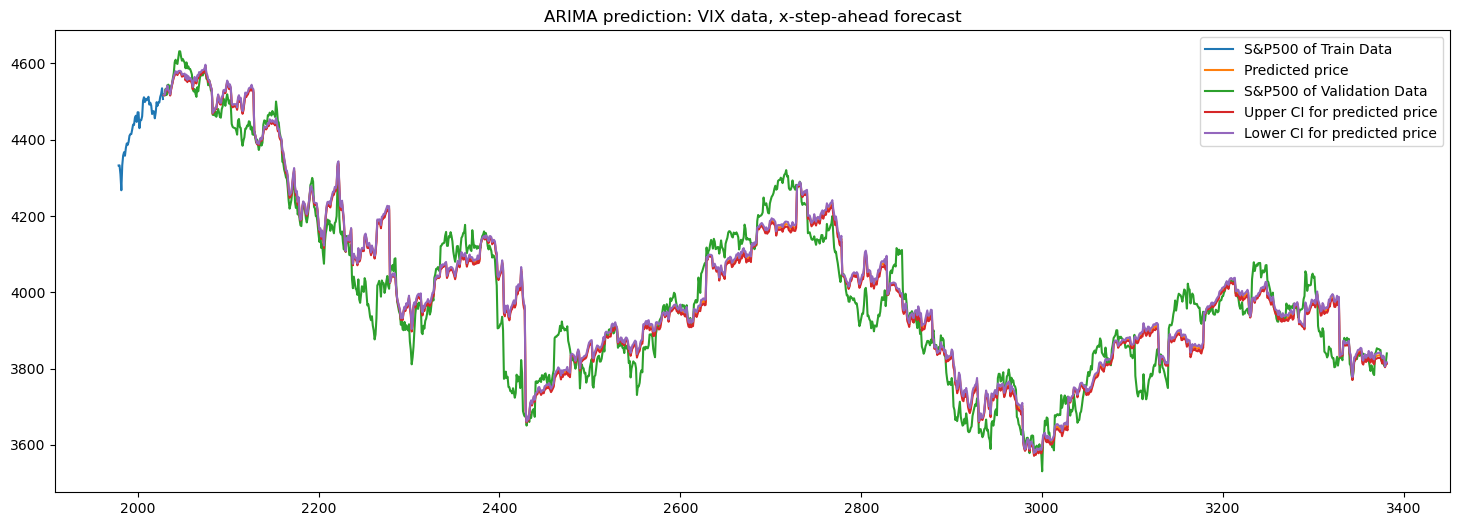

,MSE,MAE,RMSE
0,4927.8,51.8,70.2


In [38]:
forecaster = ARIMA(order = gscv.best_params_['order'])
forecaster.fit(train['SPY Last'], X = train['VIX Last'])
predictions, variance  = x_step_forecast(fh, 50, 500, forecaster, train, validation, 'SPY Last', 'VIX Last')

#plotting
plt.figure(figsize=(18,6)) 
train['SPY Last'].tail(50).plot(label='S&P500 of Train Data')
predictions[0:len(validation)].plot(label='Predicted price')
validation['SPY Last'].plot(label='S&P500 of Validation Data')
variance[variance.columns[1]].plot(label='Upper CI for predicted price')
variance[variance.columns[2]].plot(label='Lower CI for predicted price')
plt.title("ARIMA prediction: VIX data, x-step-ahead forecast")
plt.legend()
plt.show()

#loss checking
check_loss(validation, predictions)


In [39]:
#forecaster info
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                16029
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -67772.408
Date:                Mon, 09 Jan 2023   AIC                         135556.817
Time:                        19:26:25   BIC                         135602.909
Sample:                             0   HQIC                        135572.060
                              - 16029                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0125      0.174     -0.072      0.943      -0.353       0.328
x1           -24.5925      0.037   -671.242      0.000     -24.664     -24.521
ar.L1         -0.0227      0.008     -2.761      0.006      -0.039      -0.007
ar.L2         -0.0105      0.009     -1.137      0.255      -0.029       0.008
ar.L3          0.0022      0.009      0.251      0.801      -0.015       0.019
sigma2       275.6936      0.373    739.009      0.000     274.962     276.425
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          58089552.61
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            11.08
Prob(H) (two-sided):                  0.00   Kurtosis:                       297.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  2.2 Garch <a name="subsubparagraph10"></a>

In [40]:
returns = df.pct_change().dropna()*100

train_returns, validation_returns = temporal_train_test_split(returns, test_size = 0.4)


In [41]:
def GARCH_x_step_forecast(fh, x, window, train, validation, endog, exog = None, p = 1, q = 1):      
    predictions = np.zeros(len(fh))

    for i in tqdm(range(0, len(fh), x)):
        
        window_to_update = pd.concat([train, validation])*100
        if exog == None:
            garch = arch_model(window_to_update[endog], vol='garch', p=p, q=q)

        else:
            garch = arch_model(window_to_update[endog], x = window_to_update[exog], vol='garch', p=p, q=q)
            
        garch_fitted = garch.fit(first_obs = len(train) - window + i, last_obs = len(train) + i , disp = 'off')
        garch_forecast = garch_fitted.forecast(horizon=x)
        predictions[i:i+x] = np.sqrt(garch_forecast.variance.values[0])
        
    predictions = pd.DataFrame({'SNP Vol': predictions}, index = validation_returns.index )
        
        
    return predictions

In [ ]:
predictions = GARCH_x_step_forecast(fh, 1, 100, train_returns, validation_returns, 'SPY Last', 'VIX Last')
predictions[0:5]

### 2.3 VAR <a name="subsubparagraph11"></a>

In [42]:
def VAR_x_step_forecast(fh, x, window, train, validation, endog, exog = None, q = 1):      
    predictions = np.zeros(len(fh))
    
    variance = pd.DataFrame()
    variance['Lower bound'] = []
    variance['Upper bound'] = []
    for i in tqdm(range(0, len(fh), x)):
        last_variance = pd.DataFrame()
        window_to_update = pd.concat([train, validation])[len(train) - window + i : len(train) +  i]
        if exog == None:
            var = VAR(X = sm.add_constant(window_to_update[endog]))

        else:
            var = VAR(window_to_update)
        model_fitted = var.fit(q)
        lag_order = model_fitted.k_ar
        forecast_input = window_to_update.values[-lag_order:]
        
        if len(predictions) - len(predictions[:i])>=x:
            pred =  model_fitted.forecast(y=forecast_input, steps=x)
            predictions[i:i+x] = pred[:,0]
            
            last_variance['Lower bound'] = model_fitted.forecast_interval(y=forecast_input, steps=x)[1][:, 0]
            last_variance['Upper bound'] = model_fitted.forecast_interval(y=forecast_input, steps=x)[2][:, 0]

        else:
            leftovers = len(predictions) - len(predictions[:i])
            pred =  model_fitted.forecast(y=forecast_input, steps=leftovers)
            predictions[i:i+leftovers] = pred[:,0]
            
            last_variance['Lower bound'] = model_fitted.forecast_interval(y=forecast_input, steps=leftovers)[1][:, 0]
            last_variance['Upper bound'] = model_fitted.forecast_interval(y=forecast_input, steps=leftovers)[2][:, 0]
            
        variance = pd.concat([variance, last_variance])

    predictions = pd.DataFrame({'SNP pred': predictions}, index = validation.index)['SNP pred']
        
        
    return predictions, variance

###### x-step-forecasting for VAR on S&P500 with VIX information

  0%|          | 0/1353 [00:00<?, ?it/s]

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

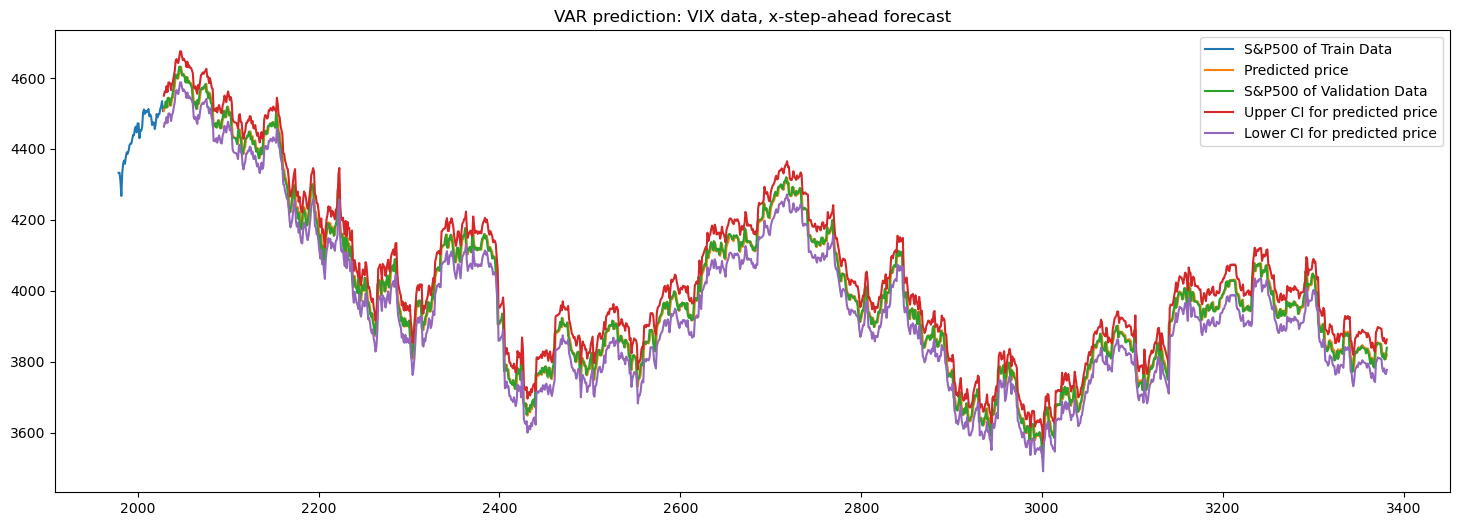

,MSE,MAE,RMSE
0,489.7,15.0,22.1


In [45]:
predictions, variance = VAR_x_step_forecast(fh, 1, 500, train, validation,'SPY Last','VIX Last')
variance = variance.set_index(keys = validation.index)

#plotting
plt.figure(figsize=(18,6)) 
train['SPY Last'].tail(50).plot(label='S&P500 of Train Data')
predictions[0:len(validation)].plot(label='Predicted price')
validation['SPY Last'].plot(label='S&P500 of Validation Data')
variance['Upper bound'].plot(label='Upper CI for predicted price')
variance['Lower bound'].plot(label='Lower CI for predicted price')
plt.title("VAR prediction: VIX data, x-step-ahead forecast")
plt.legend()
plt.show()

#loss checking
check_loss(validation, predictions)

## 3. Strategies <a name="subparagraph3"></a>

##### Functions for moving average, bollinger bands and MACD

In [89]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, predict = False, predicted_std = None, rate=20):
    sma = get_sma(prices, rate)
    if predict==True:
        bollinger_up = sma + predicted_std * 2
        bollinger_down = sma - predicted_std * 2
    else:
        std = prices.rolling(rate).std()
        bollinger_up = sma + std * 2 # Calculate top band
        bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

def get_macd(price, slow, fast, smooth):
    macd = pd.DataFrame()
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd['macd'] = pd.DataFrame(exp1 - exp2)
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


### 3.1. Simple Bollinger Bands <a name="subsubparagraph12"></a> 

In [90]:
new_df = pd.concat([train[-20:], validation])

In [91]:
spent = 0
profits = 0
buy_price, sell_price = [], []
buy_time = []
sell_time = []

# Starting with 21 because first 20 that was taken from train dataset are used for finding moving average
for i in tqdm(range(21,len(new_df['SPY Last']))):
    
    # Getting new data by expanding window
    data = new_df['SPY Last'].iloc[:i]
    index = pd.DataFrame(new_df['SPY Last']).iloc[i].name
    
    # Getting bollinger bands
    bollinger_up, bollinger_down = get_bollinger_bands(data)
    
    # Getting moving average
    sma = get_sma(data, 20)
    
    # if latest price above upper bollinger band then it's signal to sell
    if bollinger_up.iloc[-1] < data.iloc[-1]:
        sell_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        sell_time.append(index)
    
    # if latest price below lower bollinger band then it's signal to buy
    elif bollinger_down.iloc[-1] > data.iloc[-1]:
        buy_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        buy_time.append(index)
        
    # if price around moving average the porfolio should have zero position
    elif (data.iloc[-2]-sma.iloc[-2])*(data.iloc[-1] - sma.iloc[-1])<=0:
        if buy_price != []:
            profits += np.sum(np.array(buy_price) - np.array([data.iloc[-1]]*len(np.array(buy_price))))
        if sell_price != []:
            profits += np.sum(np.array([data.iloc[-1]]*len(np.array(sell_price))) - np.array(sell_price))


        
        
    

  0%|          | 0/1352 [00:00<?, ?it/s]

In [92]:
print(f'Profitability: {np.round(profits/spent ,2)}%')

Profitability: 0.2%


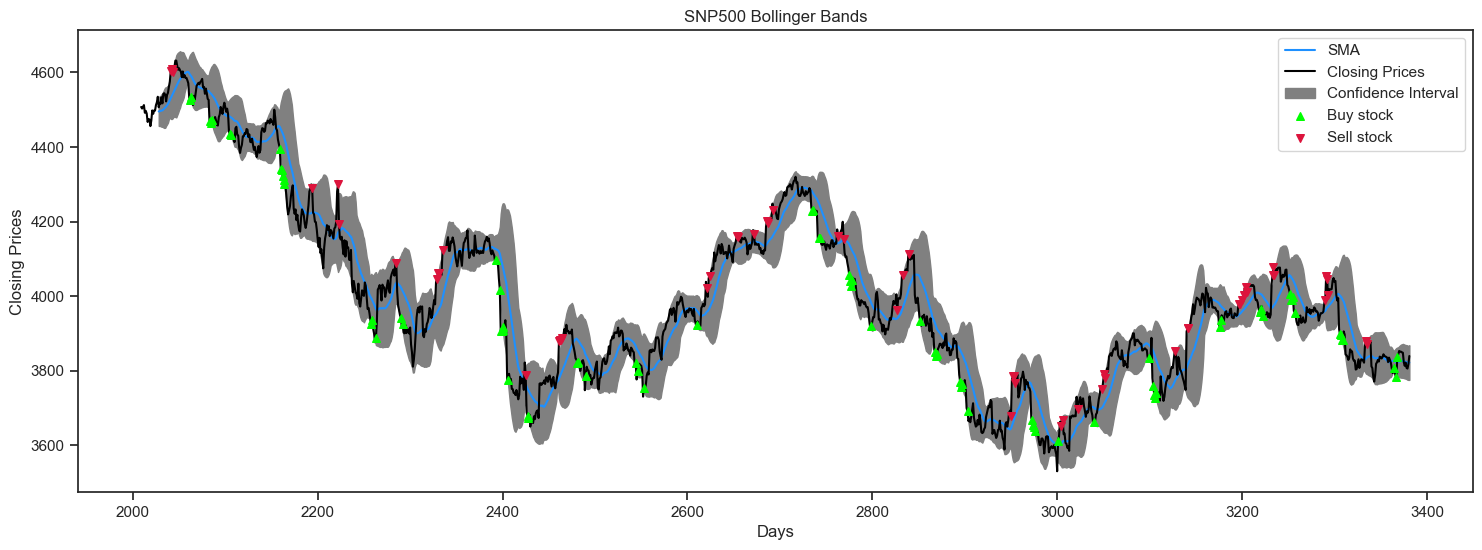

In [93]:
x = np.arange(new_df.index[0], new_df.index[-1]+1)
bollinger_up, bollinger_down = get_bollinger_bands(new_df['SPY Last'])
sma =  get_sma(new_df['SPY Last'], 20)

plt.figure(figsize=(18,6)) 
plt.title('SNP500' + ' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(sma, label='SMA', color = "dodgerblue")
plt.plot(new_df['SPY Last'], label='Closing Prices', color = "black")
plt.fill_between(x,bollinger_up, bollinger_down, color = 'grey', label='Confidence Interval')
plt.scatter(buy_time, new_df.loc[buy_time]['SPY Last'], marker='^', s=30, c="lime", label="Buy stock", zorder=2)
plt.scatter(sell_time, new_df.loc[sell_time]['SPY Last'], marker='v', s=30, c="crimson", label="Sell stock", zorder=2)


plt.legend()
plt.show()

## добавить моменты покупки и продажи

### 3.2. Bollinger Bands + VAR <a name="subsubparagraph13"></a> 

In [94]:
spent = 0
profits = 0
buy_price, sell_price = [], []
buy_time = []
sell_time = []

# Starting with 21 because first 20 that was taken from train dataset are used for finding moving average
for i in tqdm(range(21,len(new_df['SPY Last']))):
    
    # Getting new data by expanding window
    data = new_df['SPY Last'].iloc[:i]
    vix = new_df['VIX Last'].iloc[:i]
    window_to_update = new_df[['SPY Last','VIX Last']].iloc[:i]
    index = pd.DataFrame(new_df['SPY Last']).iloc[i].name

    
    # Getting bollinger bands
    bollinger_up, bollinger_down = get_bollinger_bands(data)
    
    # Getting moving average
    sma = get_sma(data, 20)
    
    #var one-step-forecast prediction
    var = VAR(window_to_update)
    model_fitted = var.fit(1)
    lag_order = model_fitted.k_ar
    forecast_input = window_to_update.values[-lag_order:]
    pred = model_fitted.forecast(y=forecast_input, steps=1)[0][0]
    
    
    
    # if latest price above upper bollinger band and predicted price lower than latest then it's signal to sell
    if bollinger_up.iloc[-1] < data.iloc[-1] and pred < data.iloc[-1] :
        sell_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        sell_time.append(index)
        
    # if latest price below lower bollinger band and predicted price higher than latest then it's signal to buy
    elif bollinger_down.iloc[-1] > data.iloc[-1] and pred > data.iloc[-1]:
        buy_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        buy_time.append(index)
        
    # if price around moving average the porfolio should have zero position
    elif (data.iloc[-2]-sma.iloc[-2])*(data.iloc[-1] - sma.iloc[-1])<=0:
        if buy_price != []:
            profits += np.sum(np.array(buy_price) - np.array([data.iloc[-1]]*len(np.array(buy_price))))
        if sell_price != []:
            profits += np.sum(np.array([data.iloc[-1]]*len(np.array(sell_price))) - np.array(sell_price))

  0%|          | 0/1352 [00:00<?, ?it/s]

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

In [95]:
print(f'Profitability: {np.round(profits/spent ,2)}%')

Profitability: 1.13%


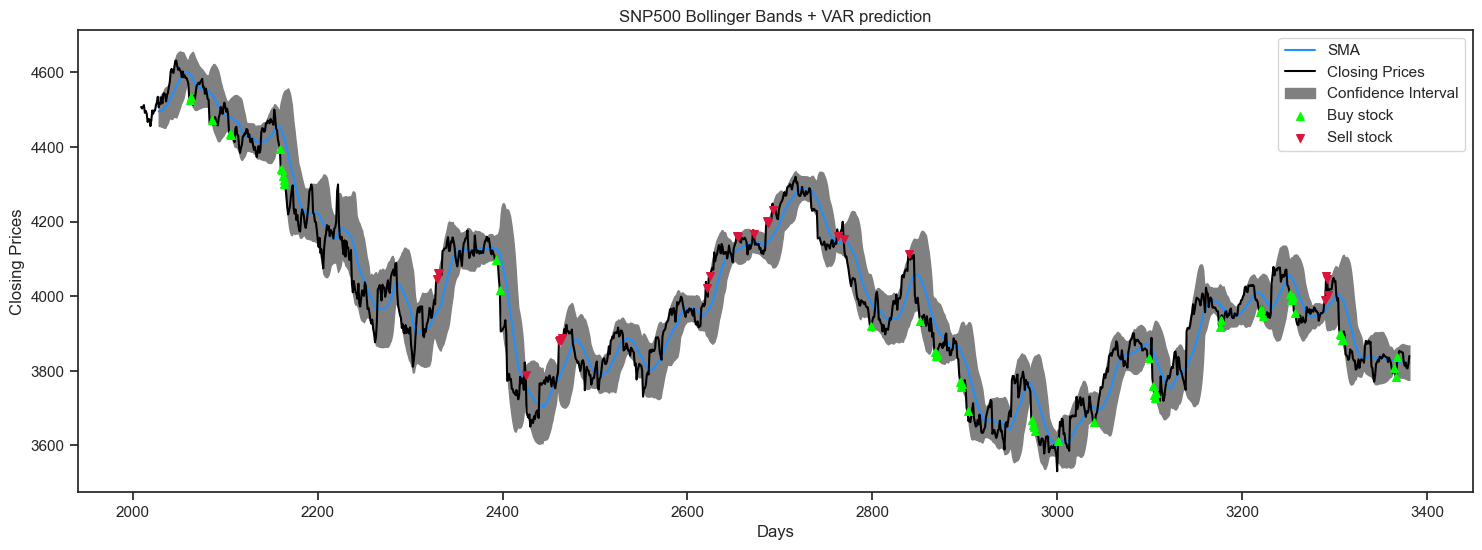

In [96]:
x = np.arange(new_df.index[0], new_df.index[-1]+1)
bollinger_up, bollinger_down = get_bollinger_bands(new_df['SPY Last'])
sma =  get_sma(new_df['SPY Last'], 20)

plt.figure(figsize=(18,6)) 
plt.title('SNP500' + ' Bollinger Bands + VAR prediction')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(sma, label='SMA', color = "dodgerblue")
plt.plot(new_df['SPY Last'], label='Closing Prices', color = "black")
plt.fill_between(x,bollinger_up, bollinger_down, color = 'grey', label='Confidence Interval')
plt.scatter(buy_time, new_df.loc[buy_time]['SPY Last'], marker='^', s=30, c="lime", label="Buy stock", zorder=2)
plt.scatter(sell_time, new_df.loc[sell_time]['SPY Last'], marker='v', s=30, c="crimson", label="Sell stock", zorder=2)


plt.legend()
plt.show()

### 3.3. Bollinger Bands (2 SD GARCH Volatility) + VAR <a name="subsubparagraph14"></a> 

In [97]:
spent = 0
profits = 0
buy_price, sell_price = [], []
buy_time = []
sell_time = []

# Starting with 21 because first 20 that was taken from train dataset are used for finding moving average
for i in tqdm(range(21,len(new_df['SPY Last']))):
    
    # Getting new data by expanding window
    data = new_df['SPY Last'].iloc[:i]
    vix = new_df['VIX Last'].iloc[:i]
    window_to_update = new_df[['SPY Last','VIX Last']].iloc[:i]
    index = pd.DataFrame(new_df['SPY Last']).iloc[i].name

    
    # Getting bollinger bands
    bollinger_up, bollinger_down = get_bollinger_bands(data)
    
    # Getting moving average
    sma = get_sma(data, 20)
    
    #VAR one-step-forecast prediction
    var = VAR(window_to_update)
    model_fitted = var.fit(1)
    lag_order = model_fitted.k_ar
    forecast_input = window_to_update.values[-lag_order:]
    pred = model_fitted.forecast(y=forecast_input, steps=1)[0][0]
    
    #GARCH one-step-forecast prediction
    data_returns = data.pct_change().dropna()*1000
    garch = arch_model(data_returns, x = vix, vol='garch', p=1, q=1)
    garch_fitted = garch.fit(disp = 'off')
    garch_forecast = garch_fitted.forecast(horizon=1)
    pred_vol = np.sqrt(garch_forecast.variance.values[0])/10
    data_pr = pd.concat([data,pd.Series(pred, index = [len(data)])])
    
    #bollinger bands prediction
    bollinger_up_pr, bollinger_down_pr = get_bollinger_bands(data_pr, predict = True, predicted_std = pred_vol)

    # if latest price above upper bollinger band and predicted upper bollinger band above predicted price 
    # then it's signal to sell
    if bollinger_up.iloc[-1] < data.iloc[-1] and bollinger_up_pr.iloc[-1] >= pred :
        sell_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        sell_time.append(index)
        
    # if latest price below lower bollinger band and predicted lower bollinger band below predicted price 
    # then it's signal to sell
    elif bollinger_down.iloc[-1] > data.iloc[-1] and bollinger_up_pr.iloc[-1] <= pred:
        buy_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        buy_time.append(index)

    # if price around moving average the porfolio should have zero position   
    elif (data.iloc[-2]-sma.iloc[-2])*(data.iloc[-1] - sma.iloc[-1])<=0:
        if buy_price != []:
            profits += np.sum(np.array(buy_price) - np.array([data.iloc[-1]]*len(np.array(buy_price))))
        if sell_price != []:
            profits += np.sum(np.array([data.iloc[-1]]*len(np.array(sell_price))) - np.array(sell_price))

  0%|          | 0/1352 [00:00<?, ?it/s]

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

In [98]:
print(f'Profitability: {np.round(profits/spent ,2)}%')

ZeroDivisionError: division by zero

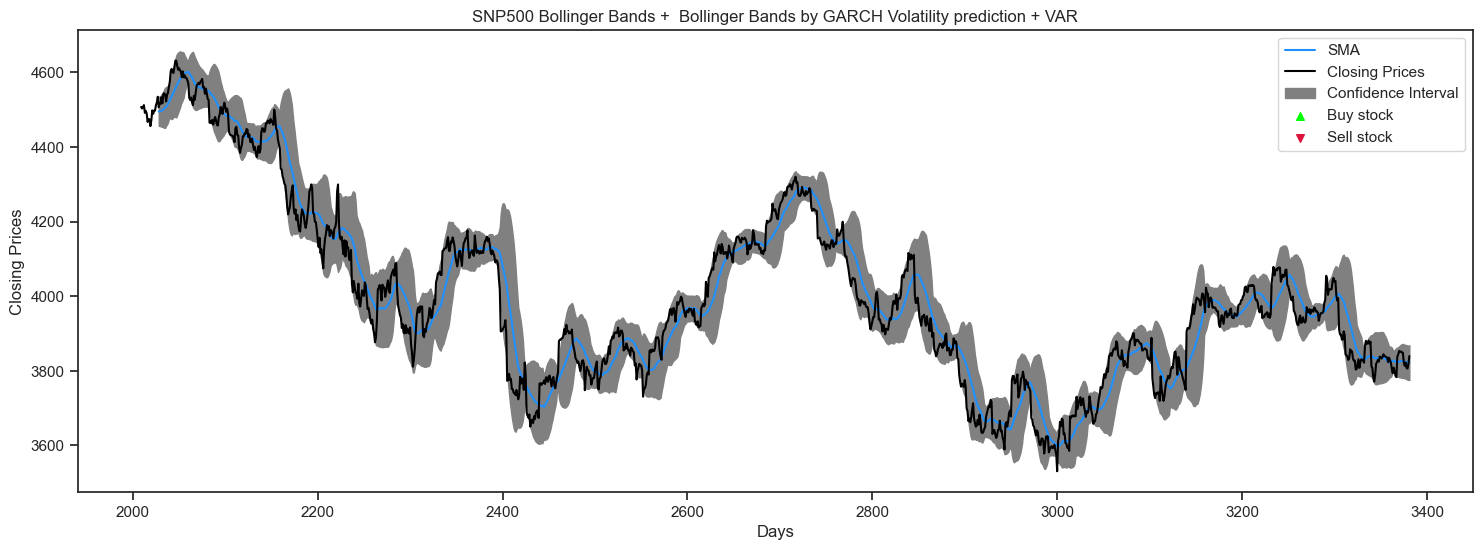

In [99]:
x = np.arange(new_df.index[0], new_df.index[-1]+1)
bollinger_up, bollinger_down = get_bollinger_bands(new_df['SPY Last'])
sma =  get_sma(new_df['SPY Last'], 20)

plt.figure(figsize=(18,6)) 
plt.title('SNP500' + ' Bollinger Bands +  Bollinger Bands by GARCH Volatility prediction + VAR')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(sma, label='SMA', color = "dodgerblue")
plt.plot(new_df['SPY Last'], label='Closing Prices', color = "black")
plt.fill_between(x,bollinger_up, bollinger_down, color = 'grey', label='Confidence Interval')
plt.scatter(buy_time, new_df.loc[buy_time]['SPY Last'], marker='^', s=30, c="lime", label="Buy stock", zorder=2)
plt.scatter(sell_time, new_df.loc[sell_time]['SPY Last'], marker='v', s=30, c="crimson", label="Sell stock", zorder=2)


plt.legend()
plt.show()

### 3.4. Bollinger Bands + 1 Min MACD <a name="subsubparagraph15"></a> 

In [100]:
spent = 0
profits = 0
buy_price, sell_price = [], []
buy_time = []
sell_time = []

# Starting with 21 because first 20 that was taken from train dataset are used for finding moving average
for i in tqdm(range(21,len(new_df['SPY Last']))):
    
    # Getting new data by expanding window
    data = new_df['SPY Last'].iloc[:i]
    bollinger_up, bollinger_down = get_bollinger_bands(data)
    index = pd.DataFrame(new_df['SPY Last']).iloc[i].name

    
    # Getting moving average
    sma = get_sma(data, 20)
    
    # Getting MACD
    macd_strategy = get_macd(data, 26, 12, 9) 

    
    # if latest price above upper bollinger band and MACD above signal line then it's a signal to sell
    if bollinger_up.iloc[-1] < data.iloc[-1] and macd_strategy['macd'].iloc[-1] >= macd_strategy['signal'].iloc[-1]:
        sell_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        sell_time.append(index)
        
    # if latest price below lower bollinger band and MACD below signal line then it's a signal to buy
    elif bollinger_down.iloc[-1] > data.iloc[-1] and macd_strategy['macd'].iloc[-1] <= macd_strategy['signal'].iloc[-1]:
        buy_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        buy_time.append(index)
        
        
    # if price around moving average the porfolio should have zero position     
    elif (data.iloc[-2]-sma.iloc[-2])*(data.iloc[-1] - sma.iloc[-1])<=0:
        if buy_price != []:
            profits += np.sum(np.array(buy_price) - np.array([data.iloc[-1]]*len(np.array(buy_price))))
        if sell_price != []:
            profits += np.sum(np.array([data.iloc[-1]]*len(np.array(sell_price))) - np.array(sell_price))

        
        
    

  0%|          | 0/1352 [00:00<?, ?it/s]

In [101]:
print(f'Profitability: {np.round(profits/spent ,2)}%')

Profitability: 0.28%


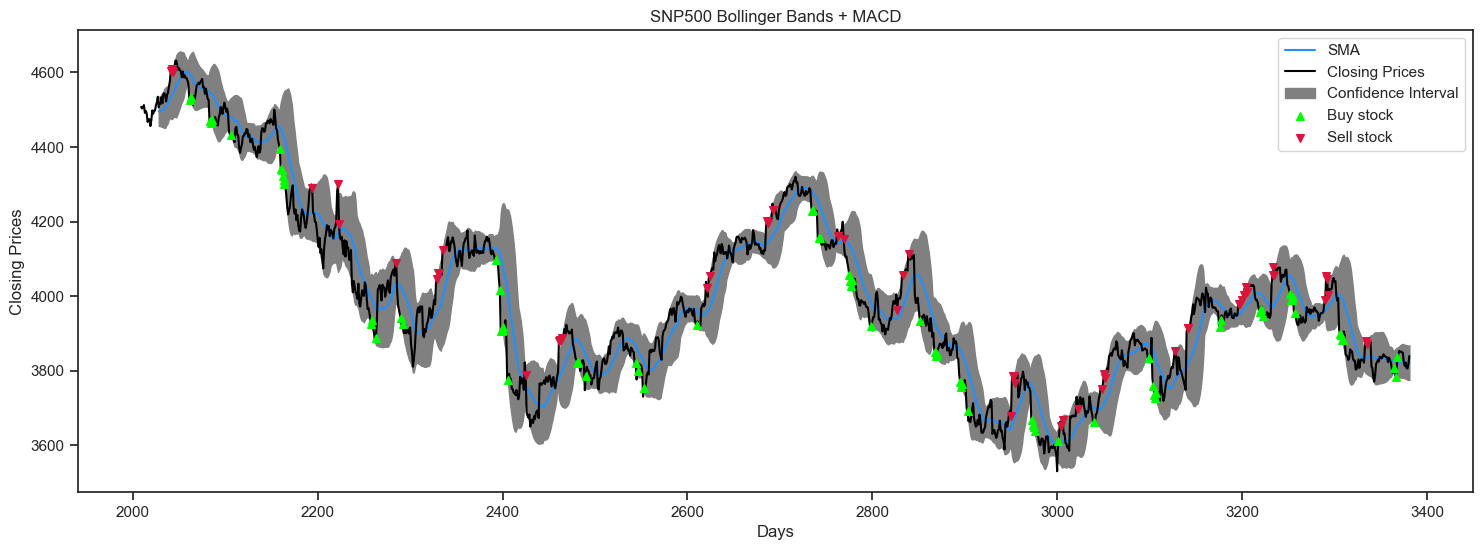

In [102]:
x = np.arange(new_df.index[0], new_df.index[-1]+1)
bollinger_up, bollinger_down = get_bollinger_bands(new_df['SPY Last'])
sma =  get_sma(new_df['SPY Last'], 20)

plt.figure(figsize=(18,6)) 
plt.title('SNP500' + ' Bollinger Bands + MACD')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(sma, label='SMA', color = "dodgerblue")
plt.plot(new_df['SPY Last'], label='Closing Prices', color = "black")
plt.fill_between(x,bollinger_up, bollinger_down, color = 'grey', label='Confidence Interval')
plt.scatter(buy_time, new_df.loc[buy_time]['SPY Last'], marker='^', s=30, c="lime", label="Buy stock", zorder=2)
plt.scatter(sell_time, new_df.loc[sell_time]['SPY Last'], marker='v', s=30, c="crimson", label="Sell stock", zorder=2)


plt.legend()
plt.show()

### 3.5. Bollinger Bands + VAR + 1 Min MACD <a name="subsubparagraph16"></a> 

In [103]:
spent = 0
profits = 0
buy_price, sell_price = [], []
buy_time = []
sell_time = []

# Starting with 21 because first 20 that was taken from train dataset are used for finding moving average
for i in tqdm(range(21,len(new_df['SPY Last']))):
    
    # Getting new data by expanding window
    data = new_df['SPY Last'].iloc[:i]
    vix = new_df['VIX Last'].iloc[:i]
    window_to_update = new_df[['SPY Last','VIX Last']].iloc[:i]
    index = pd.DataFrame(new_df['SPY Last']).iloc[i].name
    
    # Getting bollinger bands    
    bollinger_up, bollinger_down = get_bollinger_bands(data)
    
    # Getting moving average
    sma = get_sma(data, 20)
    
    # Getting MACD
    macd_strategy = get_macd(data, 26, 12, 9) 

    # VAR prediction
    var = VAR(window_to_update)
    model_fitted = var.fit(1)
    lag_order = model_fitted.k_ar
    forecast_input = window_to_update.values[-lag_order:]
    pred = model_fitted.forecast(y=forecast_input, steps=1)[0][0]
    
    
    
    # if latest price above upper bollinger band and predicted price lower than latest and predicted MACD above predicted signal line and 
    # then it's a signal to sell
    if bollinger_up.iloc[-1] < data.iloc[-1] and pred < data.iloc[-1] and macd_strategy['macd'].iloc[-1]>=macd_strategy['signal'].iloc[-1]:
        sell_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        sell_time.append(index)
        
    # if latest price below lower bollinger band and predicted price higher than latest and predicted MACD below predicted signal line and 
    # then it's a signal to sell
    elif bollinger_down.iloc[-1] > data.iloc[-1] and pred > data.iloc[-1] and macd_strategy['macd'].iloc[-1]<=macd_strategy['signal'].iloc[-1]:
        buy_price.append(data.iloc[-1])
        spent += data.iloc[-1]
        buy_time.append(index)
        
    # if price around moving average the porfolio should have zero position
    elif (data.iloc[-2]-sma.iloc[-2])*(data.iloc[-1] - sma.iloc[-1])<=0:
        if buy_price != []:
            profits += np.sum(np.array(buy_price) - np.array([data.iloc[-1]]*len(np.array(buy_price))))
        if sell_price != []:
            profits += np.sum(np.array([data.iloc[-1]]*len(np.array(sell_price))) - np.array(sell_price))

  0%|          | 0/1352 [00:00<?, ?it/s]

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ilmgf\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init

In [104]:
print(f'Profitability: {np.round(profits/spent ,2)}%')

Profitability: 1.2%


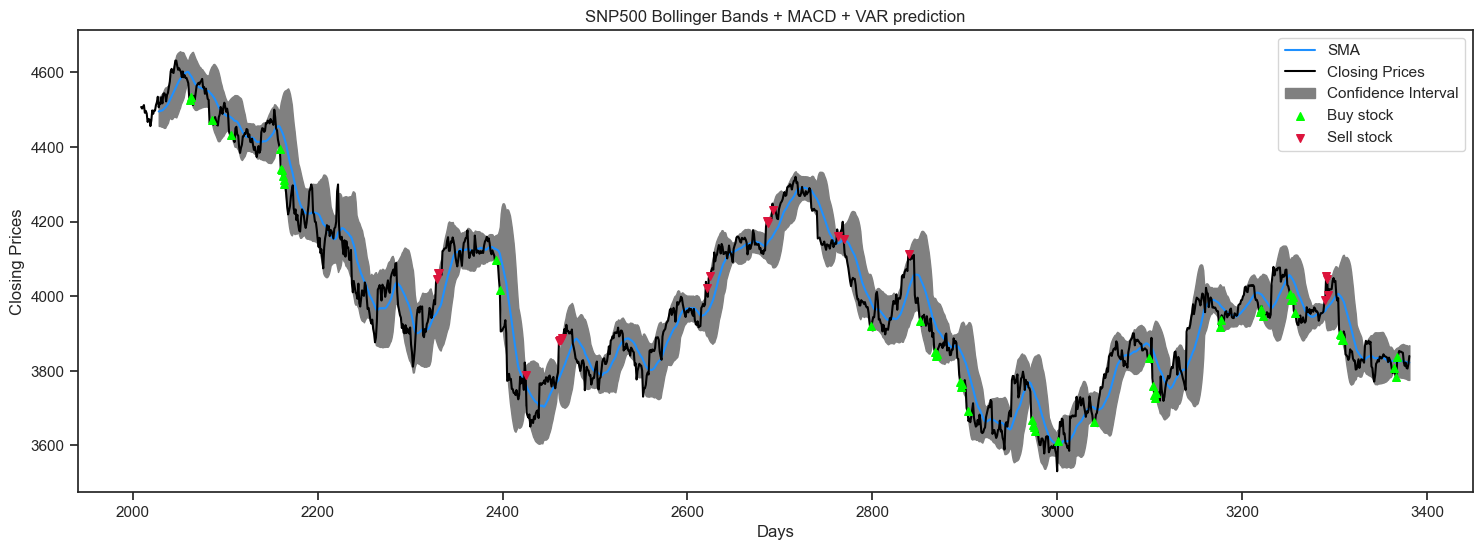

In [105]:
x = np.arange(new_df.index[0], new_df.index[-1]+1)
bollinger_up, bollinger_down = get_bollinger_bands(new_df['SPY Last'])
sma =  get_sma(new_df['SPY Last'], 20)

plt.figure(figsize=(18,6)) 
plt.title('SNP500' + ' Bollinger Bands + MACD + VAR prediction')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(sma, label='SMA', color = "dodgerblue")
plt.plot(new_df['SPY Last'], label='Closing Prices', color = "black")
plt.fill_between(x,bollinger_up, bollinger_down, color = 'grey', label='Confidence Interval')
plt.scatter(buy_time, new_df.loc[buy_time]['SPY Last'], marker='^', s=30, c="lime", label="Buy stock", zorder=2)
plt.scatter(sell_time, new_df.loc[sell_time]['SPY Last'], marker='v', s=30, c="crimson", label="Sell stock", zorder=2)


plt.legend()
plt.show()

### 3.6. Buy&Hold or Sell&Hold strategy <a name="subsubparagraph17"></a> 

In [106]:
profitability = (validation.iloc[0][0]-validation.iloc[-1][0])/validation.iloc[0][0]
print(f'Profitability of Buy&Hold: {-np.round(profitability*100 ,2)}% \nProfitability of Sell&Hold: {np.round(profitability*100 ,2)}%') 

Profitability of Buy&Hold: -15.02% 
Profitability of Sell&Hold: 15.02%
